# Plots for the 2MDM analysis

In [2]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from auxPlots import columnsDict,defaultPars

pd.option_context('display.max_columns', None)
pd.option_context('display.max_rows', None)

pd.options.mode.chained_assignment = None #Disable copy warnings

plt.rcParams.update(defaultPars)
cm = plt.colormaps['RdYlBu']

#### Get data in pcl format and print all columns names

In [10]:
#Merge with SModelS DataFrame
pclFile = '../data/smodels_results.pcl'
dataDF = pd.read_pickle(pclFile)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [11]:
#Set points without results with r == 0
dataDF.fillna(value={'r' : 0}, inplace=True)
dataDF.sort_values(by='r',ascending=False,inplace=True)

#### Filter couplings

In [12]:
mZp = 2000.0
mChi = 65.0
gchi = np.sqrt(2)
gq = 0.25
dataDF = dataDF[(np.abs(dataDF['gchi']-gchi) < 0.001) & (dataDF['gq'] == gq) & (dataDF['mChi'] == mChi) & (dataDF['mZp'] == mZp)]
len(dataDF)

3000

### Keep only the Monojet search

In [13]:
dataDF = dataDF[dataDF['AnalysisID'] == 'CMS-EXO-20-004']
dataDF.sort_values(by='r',ascending=False,inplace=True)
# Keep only the first result per filename (with largest r)
dataDF = dataDF.groupby(level='filename').head(1)
print(len(dataDF))

2991


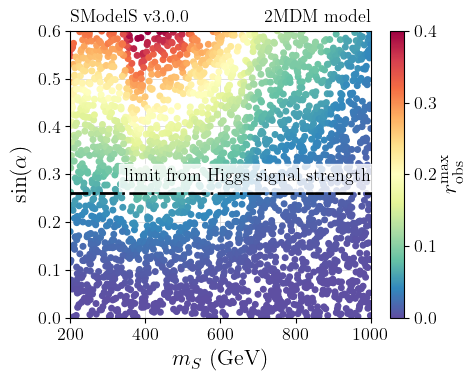

In [14]:
cm = plt.colormaps.get_cmap('Spectral_r')


x = dataDF['mS']
y = dataDF['sina']
c = np.array(dataDF['r']) / np.array(dataDF['BRs.sd.chi,chi'])

plt.hlines(0.26, 200, 1000, linestyle='dashdot', color='black')

im = plt.scatter(x,y,c=c,cmap=cm, vmin=0., vmax=0.4)
cb = plt.colorbar(im)
cb.set_label(label=r'$r_{\rm obs}^{\rm max}$')

plt.ylim(0,0.6)
plt.xlim(200,1000)
    
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')
    
plt.text(345., 0.284, r'limit from Higgs signal strength', 
        color='black',
        bbox=dict(facecolor='white', edgecolor='white',alpha=0.8))

plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')

plt.tight_layout()
plt.savefig('./figures/2mdm_rs.png')

plt.show()

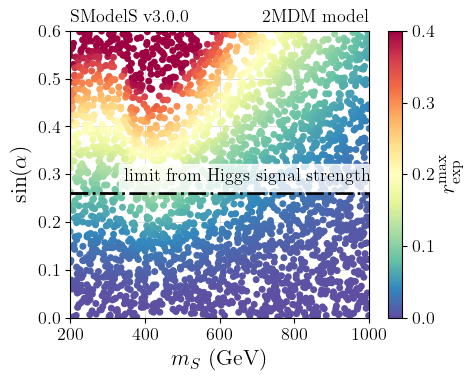

In [15]:
cm = plt.colormaps.get_cmap('Spectral_r')


x = dataDF['mS']
y = dataDF['sina']
c = np.array(dataDF['r_expected']) / np.array(dataDF['BRs.sd.chi,chi'])

plt.hlines(0.26, 200, 1000, linestyle='dashdot', color='black')

im = plt.scatter(x,y,c=c,cmap=cm, vmin=0., vmax=0.4)
cb = plt.colorbar(im)
cb.set_label(label=r'$r_{\rm exp}^{\rm max}$')

plt.ylim(0,0.6)
plt.xlim(200,1000)
    
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')
    
plt.text(345., 0.284, r'limit from Higgs signal strength', 
        color='black',
        bbox=dict(facecolor='white', edgecolor='white',alpha=0.8))

plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')

plt.tight_layout()
plt.savefig('./figures/2mdm_rexp.png')

plt.show()